## Collecting Datasets (To be finished)

1. All data sets are from Denver open-data website
2. Dataset 1 (Denver single family house sale Record) is from Parcels dataset that contains 160 million parcel transaction records since 1960 in Denver.
3. 

## Download Datasets before Running the Following Codes

* Download following datasets to the same folder of this Jupyter Notebook

1. SingleFamilyHousesWithDetails_NeighborKey_TractKey.dbf
2. NeighborhoodDemo2000.dbf
3. NeighborhoodSocialEco2010.dbf
4. Statistics_NeighborKey.dbf
5. Distances_NeighborKey.dbf
6. hpi.csv
7. cpi.csv

In [53]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as geopd
import seaborn as sns

## Load Dataset 1

### House features
1. Data related to Denver single family house sale record

This dataset (SingleFamilyHousesWithDetails_NeighborKey_TractKey) includes all Denver single family house sales data dated from 2000 to 2020, containing sale price, sale year, house features (area, number of rooms, whether remodeled, etc.)

Primary Key: SCHEDNUM (Assessment Parcel Schedule Number)

External Keys: NBHD_ID (neighborhood id), TRACT_ID (census tract id)

In [54]:
# Load house sales data
df = geopd.read_file("../Data/SingleFamilyHousesWithDetails_NeighborKey_TractKey.dbf")
houses = pd.DataFrame(df)

# Single family sales over 2.5 million has only 0.6 % of total data (365 data points)
# Remove these outliers
houses = houses[houses['SALE_PRICE'] <= 2500000]

# Column['CCYRBLT'] stands for built-year
# Create an 'AGE' column that stands for the house age when sold.
houses = houses[houses['CCYRBLT']!="None"]
houses['AGE'] = houses['SALE_YEAR'].astype(int) - houses['CCYRBLT'].astype(int)

# 'CCAGE_RM' column stands for if a house was remodeld (0 value means not)
# Create a 'Remodeled' column that stands for if a house was remodeled. 
houses['Remodeled'] = 0
houses.loc[houses['CCAGE_RM'].astype(int) > 0,'Remodeled'] = 1

# check attributes
print(houses.columns)

Index(['PIN', 'SCHEDNUM', 'CCYRBLT', 'LAND', 'SALE_MONTH', 'SALE_PRICE',
       'SALE_YEAR', 'SITUS_AD_1', 'SITUS_ZIP', 'LAND_SQFT', 'AREA_ABG',
       'BSMT_AREA', 'FBSMT_SQFT', 'GRD_AREA', 'STORY', 'BED_RMS', 'FULL_B',
       'HLF_B', 'CCAGE_RM', 'NBHD_ID', 'NBRHD_NAME', 'TRACT_ID', 'geometry',
       'AGE', 'Remodeled'],
      dtype='object')


#### Comments on Dataset 1
* Data is not balanced, more houses were sold in recent years (between 2010 and 2020), most of the houses were lower than $500,000. This could be a reference when building the model (e.g., during partition).

* Age < 0 makes sense for new constructions.

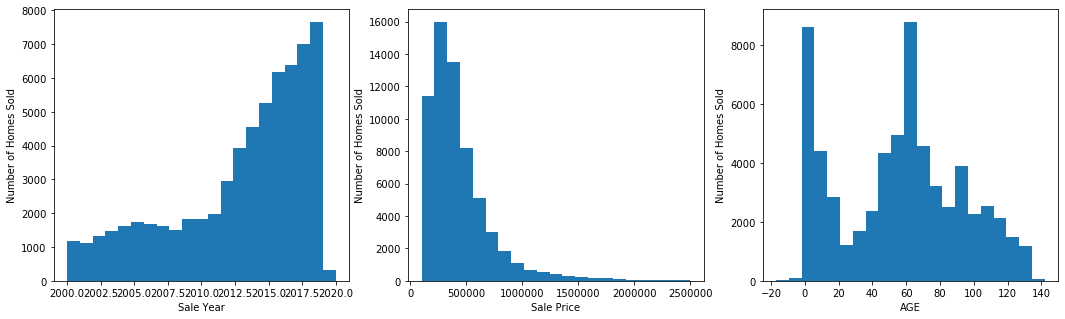

In [55]:
# plot some attributes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.hist(houses.SALE_YEAR,bins=21)
ax1.set(xlabel='Sale Year', ylabel='Number of Homes Sold')

ax2.hist(houses.SALE_PRICE,bins=21)
ax2.set(xlabel='Sale Price', ylabel='Number of Homes Sold')

ax3.hist(houses.AGE,bins=21)
ax3.set(xlabel='AGE', ylabel='Number of Homes Sold')

plt.show()

## Load Dataset 2 and 3

### Neighborhood features
1. Data related to demography
2. Data related to social-economic statistics

There are two datasets in this category: NeighborhoodDemo2000, NeighborhoodSocialEco2010. In the period of 2000 to 2020, there were twice census surveys, resulting in two versions of demographic information. It might make sense that such information should be different for houses sold in different period (i.e., 2000-2010, 2010-2020).

Primary Key: NEIGHBOR_1||NBHD_ID (neighborhood id)

In [56]:
# load social-economic data (american community survey)
df = geopd.read_file("../Data/NeighborhoodDemo2000.dbf")
Demo2000 = pd.DataFrame(df)
df = geopd.read_file("../Data/NeighborhoodSocialEco2010.dbf")
SocialEco2010 = pd.DataFrame(df)

#### Comments on dataset 2 and 3
* For preliminary test, dataset 2 and 3 are filtered to select major attributes. For now, the features selected or to be calculated are listed below:
    
    a. population - POPULATION||TTL_POPULA
    
    b. population segregation - MaxPctRace, MaxRaceTyp
    
    c. population age - PCT_LESS_1||PCT_AGELES, PCT_65_PLU||PCT_AGE65P
    
    d. population eduction - LESSTHANHS||LESS_THAN, BACHELORSO||BACHELORS
    
    c. population commute - TOTAL_COMM
    
    d. housing occupation - HOUSING_UN||TTL_HOUSIN, OWNER_OCC||OWNER_OCCU, RENTER_OCC, VACANT_HU
    
    e. household income - AVG_HH_INC, PER_CAPITA

In [57]:
# filter data
SocialEco2010['PCT_AGELES'] = SocialEco2010['PCT_AGELES'] / SocialEco2010['TTL_POPULA'] * 100

cols00 = ['NEIGHBOR_1', 'POPULATION', 'MaxPctRace', 'MaxRaceTyp', 'PCT_LESS_1', 'PCT_65_PLU', 'LESSTHANHS', 'BACHELORSO', 'TOTAL_COMM', 'HOUSING_UN', 'VACANT_HU', 'AVG_HH_INC', 'PER_CAPITA']
cols10 = ['NBHD_ID', 'TTL_POPULA', 'MaxPctRace', 'MaxRaceTyp', 'PCT_AGELES', 'PCT_AGE65P', 'LESS_THAN_', 'BACHELORS_', 'TOTAL_COMM', 'TTL_HOUSIN', 'VACANT_HU', 'AVG_HH_INC', 'PER_CAPITA']

pop00 = Demo2000.loc[:,cols00]
pop10 = SocialEco2010.loc[:,cols10]

# Create 'PCT_VAC' column standing for vacancy rate
pop00['PCT_VAC'] = pop00['VACANT_HU'] / pop00['HOUSING_UN']
pop00['POP_YEAR'] = 2000

pop10['PCT_VAC'] = pop10['VACANT_HU'] / pop10['TTL_HOUSIN']
pop10['POP_YEAR'] = 2010

pop00.rename(columns = {"NEIGHBOR_1": "NBHD_ID", 'PCT_LESS_1': 'PCT_AGELES', 'PCT_65_PLU': 'PCT_AGE65P'}, inplace=True)
pop10.rename(columns = {"TTL_POPULA": "POPULATION", "LESS_THAN_":"LESSTHANHS", 'BACHELORS_': 'BACHELORSO', "TTL_HOUSIN": "HOUSING_UN"}, inplace=True)

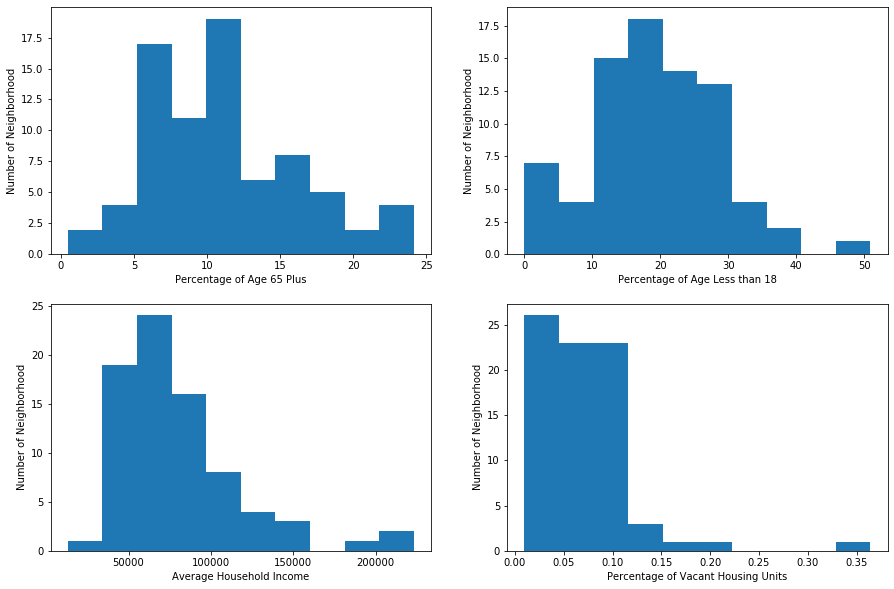

In [58]:
# plot some attributes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.hist(pop10.PCT_AGE65P)
ax1.set(xlabel='Percentage of Age 65 Plus', ylabel='Number of Neighborhood')

ax2.hist(pop10.PCT_AGELES)
ax2.set(xlabel='Percentage of Age Less than 18', ylabel='Number of Neighborhood')

ax3.hist(pop10.AVG_HH_INC)
ax3.set(xlabel='Average Household Income', ylabel='Number of Neighborhood')

ax4.hist(pop10.PCT_VAC)
ax4.set(xlabel='Percentage of Vacant Housing Units', ylabel='Number of Neighborhood')

plt.show()

## Load Dataset 4 and 5

### Neighborhood features
1. Data related to neighborhood statistics
2. Data related to neighborhood distance information

A few neighborhood features that might be useful for house price prediction, including schools, food stores, shooping centers, libraries, street lightes, trees, parks -- these are related to quality of life

Traffic related features that might be helpful in quantify mobility, including sidewalk density, intersection density.

Some features might negatively impact neighborhood image, including crimes, traffic accidents, marijuana stores.

Two datasets are generated for these features: dataset 4 (Statistics_NeighborKey) for number of features of each type in each neighborhood, and dataset 5 (Distances_NeighborKey) for the straightline distance to the nearest features of some type for each house.

Primary Key: NBHD_ID (neighborhood id), SCHEDNUM (Assessment Parcel Schedule Number)

In [59]:
# load data
df = geopd.read_file("../Data/Statistics_NeighborKey.dbf")
facs = pd.DataFrame(df)

df = geopd.read_file("../Data/Distances_NeighborKey.dbf")
dists = pd.DataFrame(df)

# Create 'Park_Coverage' and 'Tree_Coverage' columns
facs['Park_Coverage'] = facs['ParkA_SqM'] / facs['Area_SqM']
facs['Tree_Coverage'] = facs['TreesA_SqM'] / facs['Area_SqM']

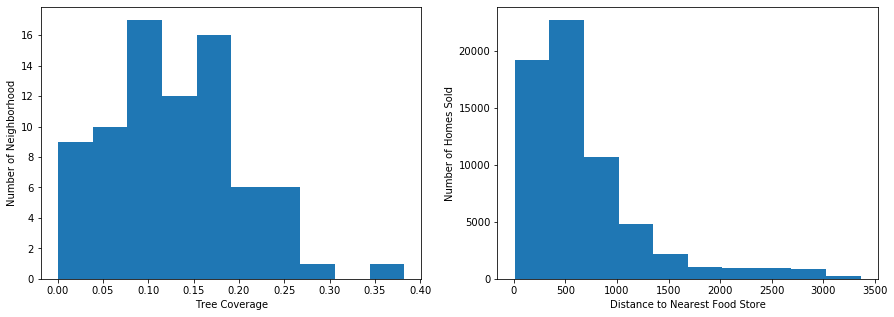

In [60]:
# plot some attributes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(facs.Tree_Coverage)
ax1.set(xlabel='Tree Coverage', ylabel='Number of Neighborhood')

ax2.hist(dists.StoreDist)
ax2.set(xlabel='Distance to Nearest Food Store', ylabel='Number of Homes Sold')

plt.show()

## Merge Datasets from 1 to 5

Up until now, we have house features and neighborhood features. To start the analysis, we will need to merge these datasets and then build models.

* Dataset 1: houses (related to Denver single family house sale record)
* Dataset 2: pop00 (related to demography)
* Dataset 3: pop10 (related to social-economic statistics)
* Dataset 4: facs (related to neighborhood statistics)
* Dataset 5: dists (related to neighborhood distance information)

In [61]:
# merge population data

# Remove unnecessary 'geometry' column first. Otherwise it will cause an error during merging
houses = houses.drop(['geometry'],axis=1)
houses = houses.astype({"NBHD_ID": int})
house00 = houses[houses['SALE_YEAR'] < 2010]
house10 = houses[houses['SALE_YEAR'] >= 2010]
print('Houses sold 2000-2010: ', len(house00), '\nHouses sold 2010-2020: ', len(house10), '\nTotal Single Family Houses Sold 2000-2020: ', len(houses))

#join house data with population data
pop00 = pop00.astype({"NBHD_ID": int})
pop10 = pop10.astype({"NBHD_ID": int})
house00_pop = pd.merge(house00, pop00, left_on='NBHD_ID', right_on='NBHD_ID')
house10_pop = pd.merge(house10, pop10, left_on='NBHD_ID', right_on='NBHD_ID')

house_pop = pd.concat([house00_pop, house10_pop])
print(list(house_pop.columns))

Houses sold 2000-2010:  15111 
Houses sold 2010-2020:  48040 
Total Single Family Houses Sold 2000-2020:  63151
['PIN', 'SCHEDNUM', 'CCYRBLT', 'LAND', 'SALE_MONTH', 'SALE_PRICE', 'SALE_YEAR', 'SITUS_AD_1', 'SITUS_ZIP', 'LAND_SQFT', 'AREA_ABG', 'BSMT_AREA', 'FBSMT_SQFT', 'GRD_AREA', 'STORY', 'BED_RMS', 'FULL_B', 'HLF_B', 'CCAGE_RM', 'NBHD_ID', 'NBRHD_NAME', 'TRACT_ID', 'AGE', 'Remodeled', 'POPULATION', 'MaxPctRace', 'MaxRaceTyp', 'PCT_AGELES', 'PCT_AGE65P', 'LESSTHANHS', 'BACHELORSO', 'TOTAL_COMM', 'HOUSING_UN', 'VACANT_HU', 'AVG_HH_INC', 'PER_CAPITA', 'PCT_VAC', 'POP_YEAR']


In [62]:
# merge facilities and distance data 

facs = facs.drop(['geometry'],axis=1)
facs = facs.astype({"NBHD_ID": int})

house_pop_fac = pd.merge(house_pop, facs, left_on='NBHD_ID', right_on='NBHD_ID')

dists = dists.drop(['geometry'],axis=1)
house_pop_fac_dist = pd.merge(house_pop_fac, dists, left_on='SCHEDNUM', right_on='SCHEDNUM')

# remove unnecessary columns
del_cols = ['NBRHD_NAME_y', 'ParkA_SqM', 'TreesA_SqM', 'LAND',
            'PIN_y', 'NBHD_ID_y', 'NBRHD_NAME_x', 
            'TRACT_ID_y', 'ParkName', 'DrugName', 'StoreType']
house_pop_fac_dist.drop(del_cols, axis = 1, inplace = True)
house_pop_fac_dist.rename(columns={"PIN_x": "PIN", 'NBHD_ID_x': 'NBHD_ID', 'TRACT_ID_x': 'TRACT_ID'}, inplace = True)
house_pop_fac_dist["SALE_MONTH"] = house_pop_fac_dist["SALE_MONTH"] // 100

print("Total columns after Mergings: ", len(house_pop_fac_dist.columns), "\n", list(house_pop_fac_dist))

Total columns after Mergings:  53 
 ['PIN', 'SCHEDNUM', 'CCYRBLT', 'SALE_MONTH', 'SALE_PRICE', 'SALE_YEAR', 'SITUS_AD_1', 'SITUS_ZIP', 'LAND_SQFT', 'AREA_ABG', 'BSMT_AREA', 'FBSMT_SQFT', 'GRD_AREA', 'STORY', 'BED_RMS', 'FULL_B', 'HLF_B', 'CCAGE_RM', 'NBHD_ID', 'TRACT_ID', 'AGE', 'Remodeled', 'POPULATION', 'MaxPctRace', 'MaxRaceTyp', 'PCT_AGELES', 'PCT_AGE65P', 'LESSTHANHS', 'BACHELORSO', 'TOTAL_COMM', 'HOUSING_UN', 'VACANT_HU', 'AVG_HH_INC', 'PER_CAPITA', 'PCT_VAC', 'POP_YEAR', 'Intersects', 'Area_SqM', 'FoodStores', 'Malls', 'Libraries', 'StLights', 'Colleges', 'K12s', 'Crimes', 'TrAccident', 'Marijuana', 'Park_Coverage', 'Tree_Coverage', 'NBRHD_NAME', 'StoreDist', 'ParkDist', 'DrugDist']


## Data Cleaning and Analysis
* Data are analyzed in each neighborhood and in each year


Display neighborhood IDs with the number of houses sold less than 100: 
    NBHD_ID  SALE_PRICE
13       16           3
34       38          53
42       47          36
56       61          10
58       63           1
73       78          96

The median number of houses sold in one year is: 1839



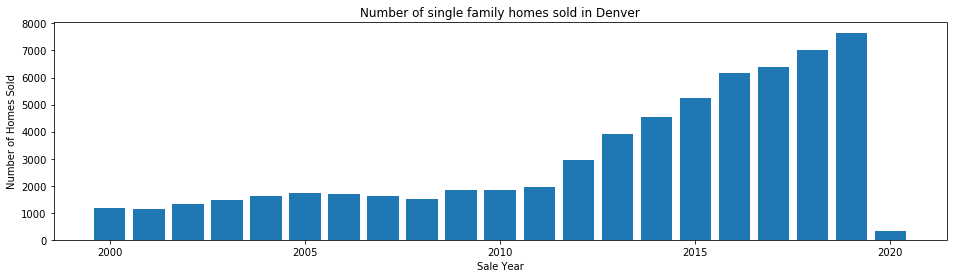

In [63]:
df = house_pop_fac_dist.copy()

# group by sale year, neighborhood
grouped = df[['NBHD_ID', 'SALE_YEAR', 'SALE_MONTH', 'SALE_PRICE','HOUSING_UN', 
              'LAND_SQFT', 'AREA_ABG', 'AGE', 'POP_YEAR']].groupby(['NBHD_ID', 'SALE_YEAR'])
nbs = grouped.count().reset_index()
nbs.rename(columns={'SALE_PRICE': 'HOUSE_SOLD'}, inplace=True)
nbsm = grouped.median().reset_index()

stat_neighbor = nbs[['NBHD_ID', 'SALE_YEAR', 'HOUSE_SOLD']]
stat_neighbor_price = nbsm[['NBHD_ID', 'SALE_YEAR', 'SALE_PRICE']]

# number of houses sold in each neighborhood
nbs_nbhd = df[['NBHD_ID', 'SALE_PRICE']].groupby(['NBHD_ID']).count().reset_index()
nbs_ids = nbs_nbhd[nbs_nbhd.SALE_PRICE <= 100]['NBHD_ID'].values

print('\nDisplay neighborhood IDs with the number of houses sold less than 100: ')
print(nbs_nbhd[nbs_nbhd.SALE_PRICE <= 100][['NBHD_ID', 'SALE_PRICE']])

# get the number of housing unit in each neighborhood
# build column['PCT_SOLD'] standing for percentage of houses sold in each neighborhood
units = grouped.max().reset_index()
nbs_units = pd.merge(nbs[['NBHD_ID', 'SALE_YEAR','HOUSE_SOLD']], units[['NBHD_ID', 'HOUSING_UN', 'SALE_YEAR']], 
                     left_on = ['NBHD_ID', 'SALE_YEAR'], right_on = ['NBHD_ID', 'SALE_YEAR'])
nbs_units['PCT_SOLD'] = nbs_units['HOUSE_SOLD'] / nbs_units['HOUSING_UN']

# get the total number of houses sold in each year
grouped = df[['NBHD_ID', 'SALE_YEAR', 'SALE_MONTH', 'SALE_PRICE','HOUSING_UN', 
              'LAND_SQFT', 'AREA_ABG', 'AGE']].groupby(['SALE_YEAR'])
nbs = grouped.count().reset_index()
nbs.rename(columns={'SALE_PRICE': 'HOUSE_SOLD'}, inplace=True)

nbs_cat = sorted(nbs.HOUSE_SOLD.unique())
nbsm = grouped.median().reset_index()

stat_year = nbs[['SALE_YEAR', 'HOUSE_SOLD']]
stat_year_price = nbsm[['SALE_YEAR', 'SALE_PRICE']]

print('\nThe median number of houses sold in one year is: %d\n' % np.median(nbs_cat))

# Display bar chart of sales from 2000 to 2020
sale_year = [2000+i for i in range(21)]
fig, ax = plt.subplots(figsize=(16,4))
ax.bar(sale_year, nbs.HOUSE_SOLD)
ax.set(xlabel='Sale Year', ylabel='Number of Homes Sold')
plt.title('Number of single family homes sold in Denver')
plt.show()

### Filter Data
* Houses sold in 2020 (less than 1000)
* Houses in selected neighborhood IDs (16,38,47,61,63,78) that have number of sold houses less than 100

In [64]:
# filter data with low records
df_f = df[(df['SALE_YEAR'] != 2020) & (~df['NBHD_ID'].isin(nbs_ids))]

# save percentage of houses sold
pct_sold = nbs_units[['NBHD_ID', 'SALE_YEAR', 'PCT_SOLD']].copy()
print("%d house sold after removing record (year 2020 and number of houses sold less than 100)" % len(df))

# add percentage of houses sold in the data
df = pd.merge(df_f, pct_sold, left_on = ['NBHD_ID', 'SALE_YEAR'], right_on = ['NBHD_ID', 'SALE_YEAR'])

63151 house sold after removing record (year 2020 and number of houses sold less than 100)


### Plot Data Basics

As a reference for partition:
* There is certain difference among neighborhood median sale price
* Median sale price increases over the year

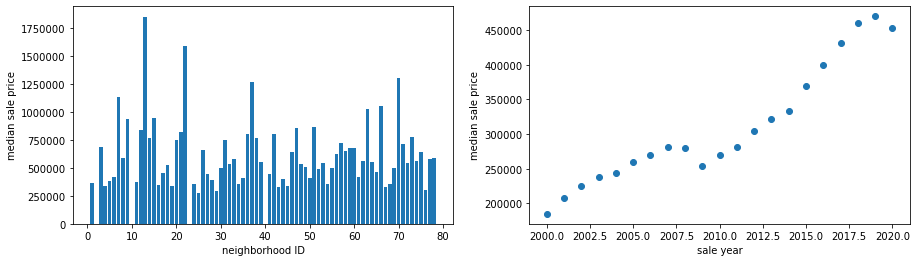

In [65]:
# plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.bar(stat_neighbor_price.NBHD_ID, stat_neighbor_price.SALE_PRICE)
ax1.set(xlabel='neighborhood ID', ylabel='median sale price')
ax2.scatter(stat_year_price.SALE_YEAR, stat_year_price.SALE_PRICE)
ax2.set(xlabel='sale year', ylabel='median sale price')

plt.show()

## Load Price Index Features

   1. CPI data: (...-2020)
* Series Id:     CUUR0000SA0L2
* Not Seasonally Adjusted
* Series Title:  All items less shelter in U.S. city average, all urban consumers, not seasonally adjusted
* Area:          U.S. city average
* Item:          All items less shelter
* Base Period:   1982-84=100
   2. HPI data: (...-2018)
* several missing data in some tract and some year, fill with median value
* it might be helpful to use sale year as the indicator of house price appreciation? If so, then only inflation adjustment though CPI is necessary
* Base Period:   2000=100


In [66]:
import warnings
warnings.filterwarnings("ignore")

# house price index data (house price appreciation)
hpi = pd.read_csv('../Data/hpi.csv', dtype = {'TRACT_ID': 'str'})
hpi = hpi[['TRACT_ID','year', 'hpi2000']]


# consumer price index data (inflation)    
cpi = pd.read_csv('../Data/cpi.csv')

# merge house sales data with consumer price index data
dfpi = pd.merge(df, cpi, left_on = ['SALE_YEAR', 'SALE_MONTH'], right_on = ['year', 'month'])

# deal with missing data in hpi
hpi_missing = hpi[hpi['hpi2000'] == '.']
hpi_full = hpi[hpi['hpi2000'] != '.']
hpi_full['hpi2000'] = hpi_full['hpi2000'].astype(float)

grouped = hpi_full.groupby(['year']).median().reset_index()
hpim = pd.merge(hpi_missing, grouped, left_on = ['year'], right_on = ['year'])
hpim = hpim.drop(columns = {'hpi2000_x'})
hpim.rename(columns = {'hpi2000_y': 'hpi2000'}, inplace = True)

hpif = pd.concat([hpi_full, hpim])

# merge house sales data with house price index data
dfpi = pd.merge(dfpi, hpif, how = 'left', left_on = ['TRACT_ID', 'SALE_YEAR'], right_on = ['TRACT_ID', 'year'])
dfpi = dfpi.drop(['year_x', 'year_y', 'month'], axis = 1)

# appreciation adjustment
dfpi['SALE_PRICE_HPI_ADJ'] = dfpi['SALE_PRICE'] / dfpi['hpi2000'] * 100

# inflation adjustment
dfpi['SALE_PRICE_CPI_ADJ'] = dfpi['SALE_PRICE'] / dfpi['cpi'] * 100

### Comments of adjusted sale price
* After CPI adjustment and log transform, sale prices seems to be normally distributed
* sale prices increase over this period, however, after inflation adjustment, the magnitude of such increase shrinks.

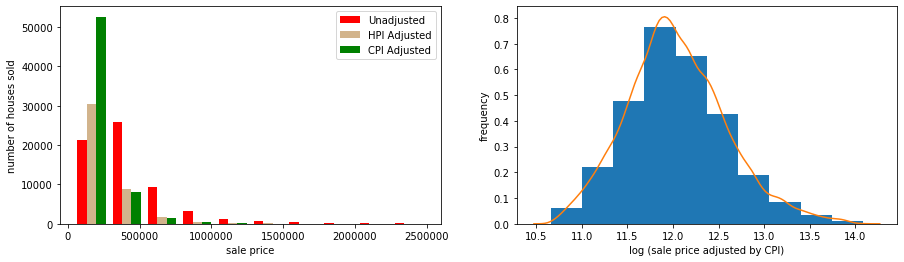

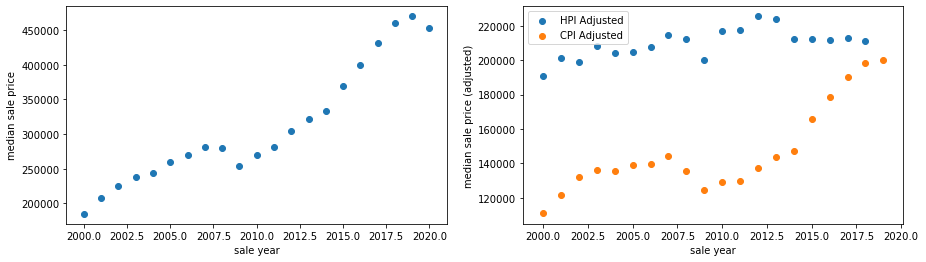

In [67]:
# compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
colors = ['red', 'tan', 'green']
labels = ['Unadjusted', 'HPI Adjusted', 'CPI Adjusted']

ax1.hist([dfpi.SALE_PRICE, dfpi.SALE_PRICE_HPI_ADJ, dfpi.SALE_PRICE_CPI_ADJ], color = colors, label = labels)
ax1.set(xlabel = 'sale price', ylabel = 'number of houses sold')
ax1.legend(prop={'size': 10})

# log transform cpi adjusted house price
da = dfpi.SALE_PRICE_CPI_ADJ.transform(np.log)
ax2.hist(da, density=True)
ax2.set(xlabel = 'log (sale price adjusted by CPI)', ylabel = 'frequency')
sns.kdeplot(da, legend = False)
plt.show()

# year-based sale price
grouped = dfpi[['SALE_YEAR', 'SALE_PRICE_HPI_ADJ', 'SALE_PRICE_CPI_ADJ']].groupby(['SALE_YEAR']).median().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
ax1.scatter(stat_year_price.SALE_YEAR, stat_year_price.SALE_PRICE)
ax1.set(xlabel='sale year', ylabel='median sale price')
ax2.scatter(grouped.SALE_YEAR, grouped.SALE_PRICE_HPI_ADJ, label = 'HPI Adjusted')
ax2.scatter(grouped.SALE_YEAR, grouped.SALE_PRICE_CPI_ADJ, label = 'CPI Adjusted')
ax2.legend(prop={'size': 10})
ax2.set(xlabel='sale year', ylabel='median sale price (adjusted)')
plt.show()

## Final Data Cleaning

1. Remove unrelated columns
2. One-hot encoding categorical data
3. Convert columns containing mixed data types to float data type
4. Combine some columns
5. Save the final cleaned data set

In [68]:
print('Available columns: ', len(dfpi.columns),'\n',list(dfpi.columns))

########## columns that are not useful for analysis ##########
# remove 'ccyrblt' because of 'age'
# remove 'sale_price' because of 'sale_price_cpi_adj'
# remove price indices in the analysis
cols_desc = ['PIN', 'SITUS_AD_1', 'SITUS_ZIP', 'TRACT_ID', 'VACANT_HU',
            'Area_SqM', 'NBRHD_NAME', 'hpi2000', 'SALE_PRICE_HPI_ADJ', 'cpi']

######### categorical variables in the data ##########
cols_cat = ['MaxRaceTyp']

dfa = dfpi[dfpi.columns.difference(cols_desc)]

print('\nSelected columns: ', len(dfa.columns), '\n', list(dfa.columns))

# check irregular columns
dfa_sam = dfa.select_dtypes(include = 'object')
dfa_sam.drop(columns = cols_cat, inplace = True)

print('\nIrregular columns: ', list(dfa_sam.columns))

# irregular column type -> float
dfa[dfa_sam.columns] = dfa[dfa_sam.columns].astype(float)

# combine full bath and half bath columns
dfa['BATH_RMS'] = dfa['FULL_B'] + 0.5 * dfa['HLF_B']
dfa.drop(columns = ['FULL_B', 'HLF_B'], inplace = True)

# commuter percentage - combine population and total commuters
dfa['PER_COMM'] = dfa['TOTAL_COMM'] / dfa['POPULATION']
dfa.drop(columns = ['TOTAL_COMM', 'POPULATION'], inplace = True)

# deal with categorical variables
dfa_encode = pd.get_dummies(dfa)
dfa_encode = dfa_encode.fillna(0)

# save cleaned data
dfa_encode.to_csv('../Data/cleaned_house_records.csv')

Available columns:  58 
 ['PIN', 'SCHEDNUM', 'CCYRBLT', 'SALE_MONTH', 'SALE_PRICE', 'SALE_YEAR', 'SITUS_AD_1', 'SITUS_ZIP', 'LAND_SQFT', 'AREA_ABG', 'BSMT_AREA', 'FBSMT_SQFT', 'GRD_AREA', 'STORY', 'BED_RMS', 'FULL_B', 'HLF_B', 'CCAGE_RM', 'NBHD_ID', 'TRACT_ID', 'AGE', 'Remodeled', 'POPULATION', 'MaxPctRace', 'MaxRaceTyp', 'PCT_AGELES', 'PCT_AGE65P', 'LESSTHANHS', 'BACHELORSO', 'TOTAL_COMM', 'HOUSING_UN', 'VACANT_HU', 'AVG_HH_INC', 'PER_CAPITA', 'PCT_VAC', 'POP_YEAR', 'Intersects', 'Area_SqM', 'FoodStores', 'Malls', 'Libraries', 'StLights', 'Colleges', 'K12s', 'Crimes', 'TrAccident', 'Marijuana', 'Park_Coverage', 'Tree_Coverage', 'NBRHD_NAME', 'StoreDist', 'ParkDist', 'DrugDist', 'PCT_SOLD', 'cpi', 'hpi2000', 'SALE_PRICE_HPI_ADJ', 'SALE_PRICE_CPI_ADJ']

Selected columns:  48 
 ['AGE', 'AREA_ABG', 'AVG_HH_INC', 'BACHELORSO', 'BED_RMS', 'BSMT_AREA', 'CCAGE_RM', 'CCYRBLT', 'Colleges', 'Crimes', 'DrugDist', 'FBSMT_SQFT', 'FULL_B', 'FoodStores', 'GRD_AREA', 'HLF_B', 'HOUSING_UN', 'Intersects

### Correlation analysis

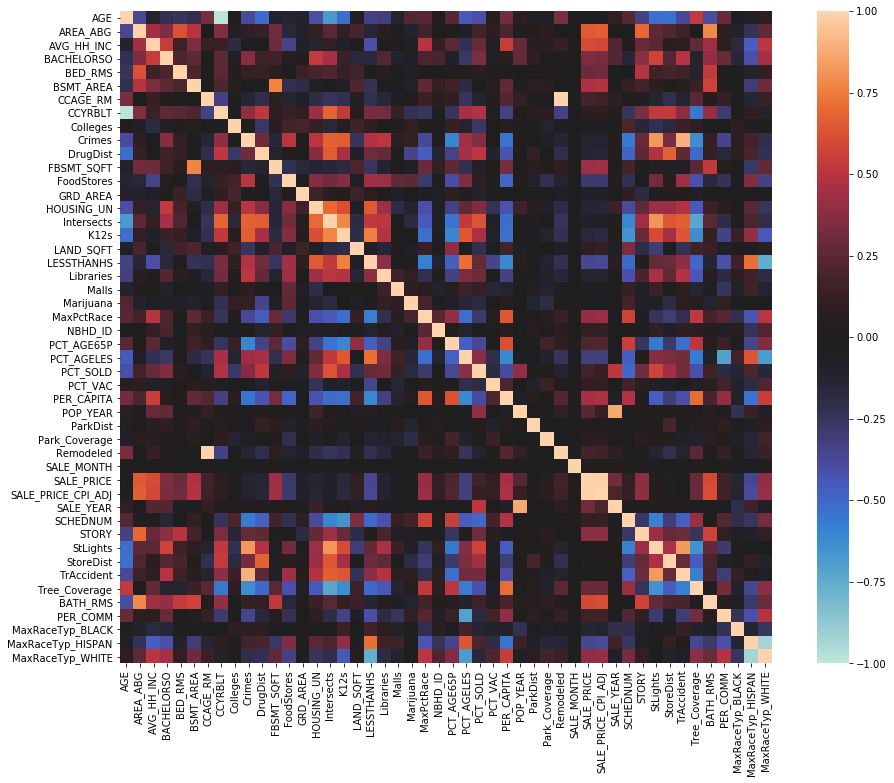

SALE_YEAR,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
NBHD_ID,,,,,,,,,,,,,,,,,,,,
1,84235.860409,94309.127909,98992.294013,95685.114354,98536.036036,98595.353863,83901.415836,75733.818364,67163.325966,66597.487126,66908.167481,55132.773882,65441.481776,73663.016255,87643.149015,105180.710340,117434.834272,133115.925765,146594.157728,146898.266952
3,124253.285544,115933.412604,111117.612639,127495.721620,140601.894647,150706.436421,139905.857741,116109.386001,122950.044451,129884.660476,114885.186766,135462.816095,124430.286814,147269.373805,163355.786642,178151.438143,204933.552523,205943.440044,219108.015421,242637.943295
4,76753.909014,88747.740231,90523.608074,92877.492877,88790.233074,78362.114076,69591.788567,63379.435000,70929.548843,65925.694417,65573.770492,58917.022909,60295.037673,64794.816415,72123.712540,94583.342371,101672.952991,120809.269798,136794.183011,132169.089767
5,84606.201876,88914.723907,95962.551200,86206.896552,97114.317425,93233.341037,93745.477437,76555.607603,71721.361894,66080.061211,63542.532424,61403.106814,61186.659483,75629.765810,77180.142924,93823.718636,102819.489211,127379.286676,137221.851825,136094.347406
6,120481.927711,131578.947368,134581.626682,130384.836301,137485.970819,129605.618585,122926.843112,119735.802494,114862.513053,104131.445736,112588.669617,98904.956591,104245.299975,115405.304949,118780.842031,135908.737310,153589.315526,163127.375432,176118.745949,179835.277718


In [69]:
# cleaned data set: dfa_encode

matrix = dfa_encode.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(matrix, vmax=1.0, vmin = -1.0, center=0, square=True)
plt.show()

groups = dfa_encode[['SALE_YEAR', 'NBHD_ID', 'SALE_PRICE_CPI_ADJ']].groupby(['SALE_YEAR', 'NBHD_ID'])
median_price = groups.median().reset_index()
counts = groups.count().reset_index()

pd.pivot_table(median_price, values = 'SALE_PRICE_CPI_ADJ', index = 'NBHD_ID', columns = 'SALE_YEAR').head()